# Computational Assignment 1:
Baseball and Golf

Audun Sørheim and Jonas Gran Melandsør

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1: Baseball

A baseballs trajectory through the air can be described as a falling object where the only force acting on the ball is the gravitional force. Then Newtons second law gives the expression for the acceleration components in two dimensions:

$$a_x = 0 $$ 
$$a_y = - g $$

However this model is too elementary to show the interesting physics behind baseball, which have fascinated physicists for decades. One way of complicating the model of the baseball is to add a dragforce. 

In [2]:
# Constants for later use

g = 9.81 # m/s^2, gravitational acceleration
v_d = 35 # m/s,
delta = 5 # m/s, 
m = 0.149 # kg, mass of baseball
r = 7.6/2*1e-3 # m, radius of baseball

S_0 = 4.1e-4*m # numerical coefficient

In [3]:
### Forces 

def B_2(v, m_b=m, v_d=v_d, delta=delta): # Drag coefficient
    return (0.0039 + 0.0058/(1 + np.exp((v - v_d)/delta)))*m_b

def F_drag_x(B_2, v, v_wind, v_x): # Drag force in x-dircetion
    return -B_2*np.linalg.norm(v - v_wind)*(v_x - v_wind[0])

def F_drag_y(B_2, v, v_wind, v_y): # Drag force in y-direction
    return -B_2*np.linalg.norm(v - v_wind)*v_y

def F_M(S_0, w, v_x):  # Magnus force
    return S_0*w*v_x

def F_lateral(m, g, theta): # Lateral force on knuckleball
    return m*g*0.5*(np.sin(4*theta) - 0.25*np.sin(8*theta) + 0.08*np.sin(12*theta) - 0.025*np.sin(16*theta))


In [4]:
# Solver for the ODEs 

def ode_solver(f, q0, t0, step_length):
    '''
    parameters: f, the system we eould like to solve.
                q0, initial conditions.
                t0, end initial time.
                step_length, length of each iteration step.
    returns: the solution of the system for every t.
    '''

    #Initializing:
    q_num = np.array([q0])    # Array for q-values
    t_num = np.array([t0])    # Array for time

    qn = q0                # temporary values for q and t
    tn = t0
    
    # Main loop
    while qn[2] > 0:    # Until ball hits the ground     
        qn, tn = RK4(f, qn, tn, step_length)    # One step of Runge-Kutta 4 method
        q_num = np.concatenate((q_num, np.array([qn])))
        t_num = np.append(t_num, tn)
    return q_num.T, t_num

# Runga Kutta of 4th order
def RK4(f, q, t, step_length):
    """
    parameters: f, the system we would like to solve.
                q, postion vector, q = [x,y,z]
                t, general variable
                step_length, length of each iteration step.
    returns: next time step with corresponding solution.
    """
    k1 = f(t, q)
    k2 = f(t + 0.5*step_length, q + 0.5*step_length*k1)
    k3 = f(t + 0.5*step_length, q + 0.5*step_length*k2)
    k4 = f(t + step_length, q + step_length*k3)

    q_next = q + step_length*(k1 + 2*k2 + 2*k3 + k4)/6
    t_next = t + step_length
    
    return q_next, t_next

### 1a) - Batted ball

Assume only two dimensions, $x$ and $y$ and no rotation. The only force working in the $x$-direction is the drag force 

$$\frac{B_{2,x}}{m}=0.0039+\frac{0.0058}{1+exp{[(v_x-v_d)/\Delta]}}$$

The drag force is similar for the $y$-direction
$$\frac{B_{2,y}}{m}=0.0039+\frac{0.0058}{1+exp{[(v_y-v_d)/\Delta]}}$$

but here, gravity does also effect the vertical of the ball. Therefore the acceleration components can be described as:

$$a_x=-\frac{B_{2,x}}{m^2}=\left(0.0039+\frac{0.0058}{1+exp{[(v_x-v_d)/\Delta]}}\right)/m$$
$$a_y=-\left(g+\frac{B_{2,y}}{m}\right)/m=-g-\left(0.0039+\frac{0.0058}{1+exp{[(v_y-v_d)/\Delta]}}\right)/m$$

We have the following system:

$$q(t)=[x(t) \hspace{0.2cm} v_x(t) \hspace{0.2cm} y(t)  \hspace{0.2cm} v_y(t)],$$

which gives the following derivative:

$$f(t, q) = \frac{dq}{dt} = [v_x(t) \hspace{0.2cm} a_x(t) \hspace{0.2cm} v_y(t) \hspace{0.2cm} a_y(t)]$$

In [5]:
y_0 = 0.76  # height of the ball when batted, based on the height of the box players are allowed to hit between

def find_optimal_angle(f, v_wind=0, v_i = 50, theta_min=0, theta_max=60, dtheta=1, step_length=1e-2):
    '''
    Parameters:
                f, the system to be solved.
                v_wind, velocity of the wind.
                v_i, initial velocity
                theta_min, start of iteration angles.
                theta_max, end of iteration angkes.
                dtheta, the interval of iteration angles.
                step_length, length of each iteration step in RK4.
    returns, a solution to the system, time-array, longest x-trajectory, optimal angle, all angles iterated through.
    '''
    
    angles = np.arange(theta_min, theta_max, dtheta)
    
    best_angle = 0

    x_max_arr = np.zeros_like(angles)
    i = 0
    for angle in angles:
        v_0x = v_i*np.cos(angle*np.pi/180)
        v_0y = v_i*np.sin(angle*np.pi/180)        

        q0 = np.array([0, v_0x + v_wind, y_0, v_0y])
        q, t = ode_solver(f, q0, 0, step_length)

        x_max_arr[i] = q[0][-1]
        if x_max_arr[i] > x_max_arr[i-1]:  # Saving the optimal angle and system with longest trajectory in x-direction
            best_angle = angle
            q_max = q
        i += 1
        
    return q_max, t, x_max_arr, best_angle, angles

The longest trajectory in x-direction is 120 meters which happens at approximately 30.0


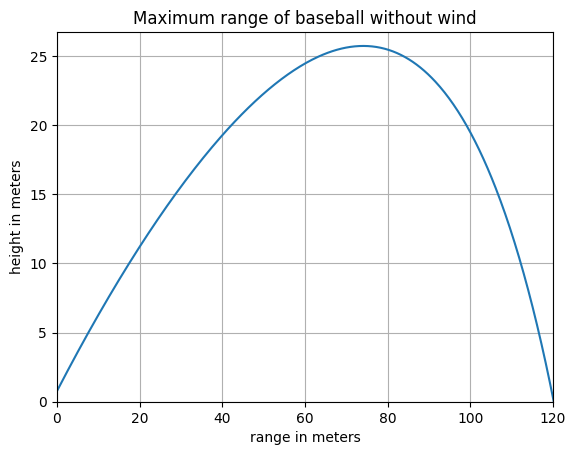

In [6]:
def f(t, q):
    dq = np.array([q[1], -B_2(q[1])/m*q[1]**2, q[3], -g-B_2(q[3])/m*q[3]**2])
    return dq

q, t, x_max_arr, optimal_angle, angle_arr = find_optimal_angle(f)
print(f'The longest trajectory in x-direction is {q[0][-1]:.0f} meters which happens at approximately {optimal_angle:.1f}')

np.savez('Without_wind', q = q, time = t, optimal_angle = optimal_angle, angles = angle_arr, x_arr = x_max_arr, x_max = np.max(x_max_arr))

plt.figure()
plt.title("Maximum range of baseball without wind")
plt.plot(q[0], q[2])
plt.xlim(0, np.max(x_max_arr)); plt.ylim(0, np.max(q[2])+1)
plt.xlabel("range in meters"); plt.ylabel("height in meters")
plt.grid()
plt.show()

To make the system even more realistic one can add a wind blowing at a constant velocity. To simplify we assume that the wind is only blowing in the x-direction. If $v_{wind} < 0$ it is called a $headwind$, working against the balls movement. On the other hand, when $v_{wind} > 0$ it is called a $tailwind$. In both cases the dragforce is effected giving a new expression for $\frac{B_{2,x}}{m}$: 

$$\frac{B_{2,x}}{m^2}=\left(0.0039+\frac{0.0058}{1+exp{[((v_x-v_{wind})-v_d)/\Delta]}}\right)/m$$

With winds, the dragforce components can be expressed as follows:

$$F_{drag, x} = -B_2\left|\vec{v}-\vec{v}_{wind}\right|\left(v_x-v_{wind,x} \right)$$
$$F_{drag, y} = -B_2\left|\vec{v}-\vec{v}_{wind}\right|\left(v_y-v_{wind,y} \right) = -B_2\left|\vec{v}-\vec{v}_{wind}\right|v_y$$

where the in the last equality was used that the wind is only blowing in the $x$-direction.

Then the acceleration can be desribed by the following equations:

$$a_x = \frac{F_{drag,x}}{m}= - B_2\left|\vec{v}-\vec{v}_{wind}\right|\left(v_x-v_{wind,x} \right)/m$$
$$a_y = -g + \frac{F_{drag, y}}{m} = - g -B_2\left|\vec{v}-\vec{v}_{wind}\right|v_y$$.

Using the same method as above we can calculate the optimal angle for both the case of headwind, but also tailwind.

The longest trajectory in x-direction is 75 meters which happens at 25.0 degrees


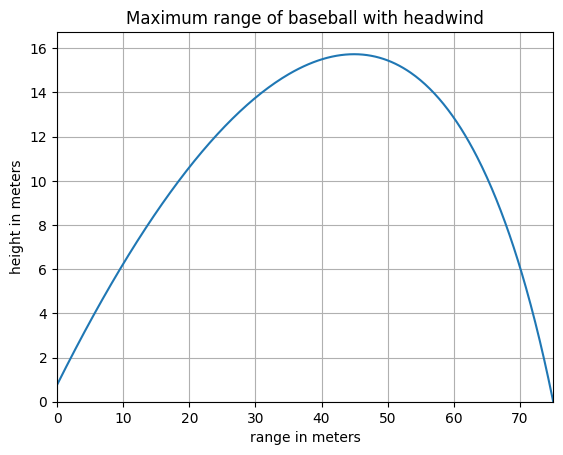

In [7]:
v_wind_arr = np.array([[-10, 0], [10, 0]]) # first element headwind, second tailwind, both in x- and y-direction

def f_headwind(t, q):  # Headwind
    v = np.array([q[1], q[3]])
    dq = np.array([q[1], F_drag_x(B_2(np.linalg.norm(v - v_wind_arr[0])), v, v_wind_arr[0], q[1])/m,
                   q[3], -g + F_drag_y(B_2(np.linalg.norm(v - v_wind_arr[1])), v, v_wind_arr[0], q[3])/m])

    return dq

q, t, x_max_arr, optimal_angle, angle_arr = find_optimal_angle(f_headwind, v_wind_arr[0][0]) # Headwind
print(f'The longest trajectory in x-direction is {q[0][-1]:.0f} meters which happens at {optimal_angle:.1f} degrees')

np.savez('Headwind', q = q, time = t, optimal_angle = optimal_angle, angles = angle_arr, x_arr = x_max_arr, x_max = np.max(x_max_arr))

plt.figure()
plt.title("Maximum range of baseball with headwind")
plt.plot(q[0], q[2])
plt.xlim(0, np.max(x_max_arr)); plt.ylim(0, np.max(q[2])+1)
plt.xlabel("range in meters"); plt.ylabel("height in meters")
plt.grid()
plt.show()

The longest trajectory in x-direction is 178 meters which happens at 42.0 degrees


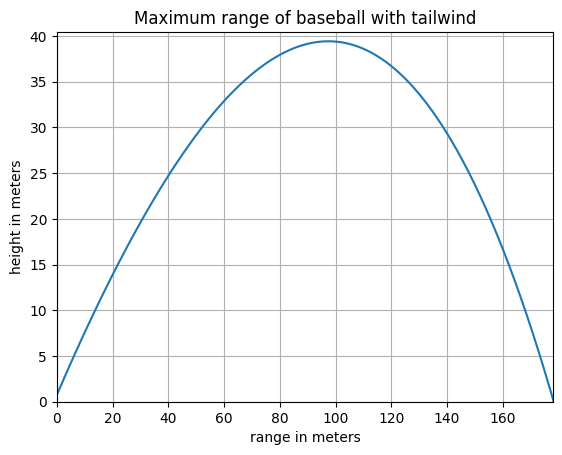

In [8]:
def f_tailwind(t, q):   # Tailwind
    v = np.array([q[1], q[3]])
    dq = np.array([q[1], F_drag_x(B_2(np.linalg.norm(v - v_wind_arr[1])), v, v_wind_arr[1], q[1])/m,
                   q[3], -g + F_drag_y(B_2(np.linalg.norm(v - v_wind_arr[1])), v, v_wind_arr[1], q[3])/m])

    return dq

q, t, x_max_arr, optimal_angle, angle_arr = find_optimal_angle(f_tailwind, v_wind_arr[1][0]) # Tailwind
print(f'The longest trajectory in x-direction is {q[0][-1]:.0f} meters which happens at {optimal_angle:.1f} degrees')

np.savez('Tailwind', q = q, time = t, optimal_angle = optimal_angle, angles = angle_arr, x_arr = x_max_arr, x_max = np.max(x_max_arr))

plt.figure()
plt.title("Maximum range of baseball with tailwind")
plt.plot(q[0], q[2])
plt.xlim(0, np.max(x_max_arr)); plt.ylim(0, np.max(q[2])+1)
plt.xlabel("range in meters"); plt.ylabel("height in meters")
plt.grid()
plt.show()

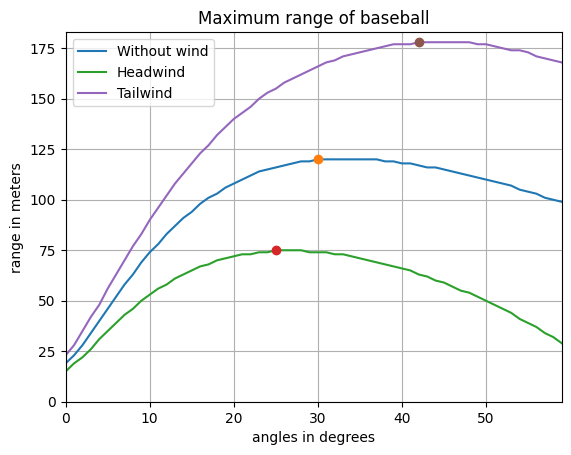

In [9]:
data_without_wind = np.load('Without_wind.npz')
data_headwind = np.load('Headwind.npz')
data_tailwind = np.load('Tailwind.npz')

index_without_wind = np.argmax(data_without_wind['x_arr'])
index_headwind = np.argmax(data_headwind['x_arr'])
index_tailwind = np.argmax(data_tailwind['x_arr'])

plt.figure()
plt.title("Maximum range of baseball")
# Without wind
plt.plot(data_without_wind['angles'], data_without_wind['x_arr'], label="Without wind") #x_max asf. of angles  
plt.plot(index_without_wind, data_without_wind['x_max'], "o")  # Maximal value of x_max
# Headwind
plt.plot(data_headwind['angles'], data_headwind['x_arr'], label="Headwind") #x_max asf. of angles 
plt.plot(index_headwind, data_headwind['x_max'], "o") # Maximal value of x_max
# Tailwind
plt.plot(data_tailwind['angles'], data_tailwind['x_arr'], label="Tailwind") #x_max asf. of angles 
plt.plot(index_tailwind, data_tailwind['x_max'], "o")  # Maximal value of x_max

plt.xlim(0, np.max(data_tailwind['angles'])); plt.ylim(0, np.max(data_tailwind['x_arr'])+5)
plt.xlabel("angles in degrees"); plt.ylabel("range in meters")
plt.legend()
plt.grid()
plt.show()

As seen in the figure above, the baseball travels furter with the tailwind, which is expected. Then the angle is larger than for headwind and without wind, going to the optimal angle of projectile motion without any other forces than gravity, $45 ^\circ$. Moreover, the headwind obtructs the baseballs movement, resulting in a shorter trajectory in the x-direction.

We are now interested in finding the required velocity of the ball leaving the bat, to hit a home run. We assume that the angle of the initial velocity is the optimal angle for each of the different winds.

In [10]:
def find_velocity_for_distance(f, angle, x_wanted, v_wind=0, v_0_start=10, delta_v=1, step_length=1e-2):
    q = np.zeros((4,1))
    v = v_0_start
    while q[0,-1] < x_wanted:
        v_0x = v*np.cos(angle*np.pi/180)
        v_0y = v*np.sin(angle*np.pi/180)            
        q0 = np.array([0, v_0x - v_wind, y_0, v_0y])
        v += delta_v
        q, t = ode_solver(f, q0, 0, step_length)
    return q, t, v


In [11]:
x_hr = 168 # meters for a homerun

# Without wind
q, t, v_max = find_velocity_for_distance(f, data_without_wind["optimal_angle"], x_hr)
print(f'Minimum velocity to hit home run without wind is v = {v_max} m/s')

# Headwind
q, t, v_max = find_velocity_for_distance(f_headwind, data_headwind["optimal_angle"], x_hr)
print(f'Minimum velocity to hit home run with headwind is v = {v_max} m/s')

# Tailwind
q, t, v_max = find_velocity_for_distance(f_tailwind, data_tailwind["optimal_angle"], x_hr)
print(f'Minimum velocity to hit home run wit tailwind is v = {v_max} m/s')

Minimum velocity to hit home run without wind is v = 64 m/s
Minimum velocity to hit home run with headwind is v = 73 m/s
Minimum velocity to hit home run wit tailwind is v = 56 m/s


As expected, the lowest required velocity is with tailwind, and the highest required velocity is with headwind.

### Excercise 1 b) - Curve ball

In [12]:
# Defining given constants 

v_i = 35     # m/s, initial velocity
y_0 = 1.8    # m, initial height
theta_0 = 0  # deg, initial throwing angle
w = 30   # 1/s, initial spin on baseball
l = 18.39 # m, distance between batter and pitcher 

In baseball the batting itself is not what fascinates most physicists. More interessing is the throwing of the ball, where one can curve the ball if thrown with an non-zero angular velocity. Then there will be difference in velocity relative to the air between the top of the ball $v-\omega r$ and the bottom $v+\omega r$ there. This results in a force acting upwards called the Magnus force. We expand to three dimension, where the $x$-direction is along the direction of the throw and $y-axis$ points upwards. If we assume only rotation about the y-axis, with constant angular velocity $\omega$, then the Magnus force can be expressed as 

$$F_M=S_0\omega v_x,$$

where $S_0$ is an numerical coefficient based on the average drag force on the ball. We set $S_0/m\approx 4.1\times 10^{-4}$, with $m=149$ g. Also assume only drag force in x-direction and no wind.

The acceleration can be decomposed into the following terms:
$$a_x = F_{drag}=-B_2vv_x$$
$$a_y = - g$$
$$a_z = - F_M = -\frac{S_0v_x\omega}{m}.$$

Then the system can be described by the following matrix:
$$q=[x, v_x, y, v_y, z, v_z] \space,$$

with the derivative

$$dq = [\dot{x}, \dot{v_x}, \dot{y}, \dot{v_y}, \dot{z}, \dot{v_z}]=\left[v_x, -\frac{B_2}{m}vv_x, v_y, -g, v_z, -\frac{S_0v_x\omega}{m}\right].$$

In [13]:
# Curveball
    # No rotation
def f_no_rotation(t, q):
    v_wind = np.array([0,0,0])
    v = np.linalg.norm(q[1] + q[3] + q[5])
    dq = np.array([q[1], F_drag_x(B_2(v), v, v_wind, q[1])/m, q[3], -g, q[5], -F_M(S_0, 0, q[1])/m])
    return dq


# With rotation along y-axis
def f_curveball(t, q):
    v_wind = np.array([0,0,0])
    v = np.linalg.norm(q[1] + q[3] + q[5])
    dq = np.array([q[1], F_drag_x(B_2(v), v, v_wind, q[1])/m, q[3], -g, q[5], -F_M(S_0, w, q[1])/m])
    return dq


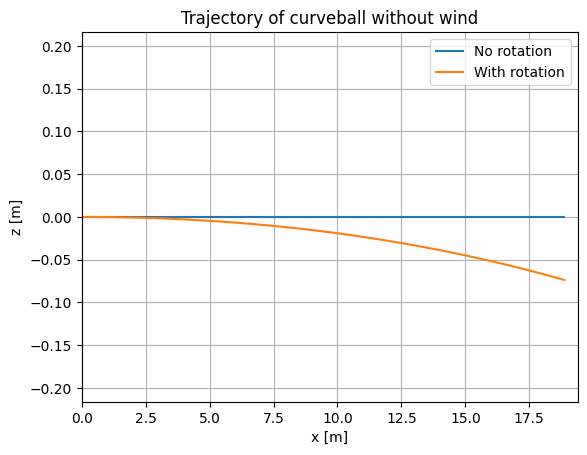

The trajectory is deflected -0.07 m in the z-direction due to the Magnus force


In [14]:
q0 = np.array([0, v_i*np.cos(theta_0), y_0, v_i*np.sin(theta_0), 0, 0])

q_no_rotation, t_no_rotation = ode_solver(f_no_rotation, q0, 0, 1e-2)  # No rotation
q_curveball, t_curveball = ode_solver(f_curveball, q0, 0, 1e-2)  # Rotation with omega = 30 s^{-1}

delta_z = q_curveball[4,-1] - q_no_rotation[4,-1]   # Deflection in z-direction

plt.figure()
plt.title("Trajectory of curveball without wind")
plt.plot(q_no_rotation[0], q_no_rotation[4], label="No rotation")
plt.plot(q_curveball[0], q_curveball[4], label="With rotation")
plt.xlim(0, l+1); plt.ylim(-43.2*1e-2/2, 43.2*1e-2/2)
plt.xlabel("x [m]"); plt.ylabel("z [m]")
plt.legend()
plt.grid()
plt.show()

print(f'The trajectory is deflected {delta_z:.2f} m in the z-direction due to the Magnus force')

### Excercise 1 c)

Since the job of the pitcher is to make it as hard as possible for the batter to hit the ball, the former has to be able to throw more than curveballs. Another technique to make the movement of the ball extra unpredictable is called knuckleball, and is characterized by its ability to make what is experienced as sudden displacements perpendicular to the vector between the pitcher and the batter. This technique takes advantage of the lateral force produced by the differences of smoothness of the ball, e.g. the stiches on the ball in opposition to the smooth surface For a knuckleball to occur, the ball has to be thrown with little spin.  

$$q=[x, v_x, y, v_y, z, v_z, \theta, \omega] \space \Rightarrow \space dq = [\dot{x}, \dot{v_x}, \dot{y}, \dot{v_y}, \dot{z}, \dot{v_z}, \dot{\theta}, \dot{\omega}]=\left[v_x, -\frac{B_2}{m}vv_x, v_y, -g, v_z, -\frac{S_0v_x\omega}{m} - \frac{F_{lateral}}{m}, \omega, 0\right]$$;

Where $\displaystyle F_{lateral} = 0.5mg\left[sin(4\theta) - 0.25sin(8\theta) + 0.08sin(12\theta) - 0.025sin(16\theta) \right]$

Here $\omega$ assumed constant, such that $\alpha = \dot{\omega}=0$ 

In [15]:
def f_knuckleball(t, q):
    v_wind = np.zeros(3)
    v = np.linalg.norm(q[1] + q[3] + q[5])
    dq = np.array([q[1], F_drag_x(B_2(v), v, v_wind, q[1])/m, q[3], -g, q[5], -F_M(S_0, q[-1], q[1])/m - F_lateral(m,g,q[6]), q[-1], 0])
    return dq


def knuckleball(f, variable, var_arr, fixed_value_1, fixed_value_2, v_wind = np.zeros(3),  step_length=1e-2):
    plt.figure()
    for var in var_arr:
        if variable == "v":
            q0 = np.array([0, var*np.cos(fixed_value_1*np.pi/180), y_0, var*np.sin(fixed_value_1*np.pi/180), 
                0, 0, fixed_value_1, fixed_value_2])
            plt.title("Trajectory of knuckleball as function of v_i")
        elif variable == "w":
            q0 = np.array([0, fixed_value_1*np.cos(fixed_value_2*np.pi/180), y_0, 
                fixed_value_1*np.sin(fixed_value_2*np.pi/180), 0, 0, fixed_value_2, var])
            plt.title("Trajectory of knuckleball as function of w")
        elif variable == "theta":
            q0 = np.array([0, fixed_value_1*np.cos(var*np.pi/180), y_0, fixed_value_1*np.sin(var*np.pi/180), 
                0, 0, var, fixed_value_2])
            plt.title("Trajectory of knuckleball as function of θ")

        q, t = ode_solver(f_knuckleball, q0, 0, step_length)

        if variable == "v":
            plt.plot(q[0], q[4], label = f'v={var}')
        elif variable == "w":
            plt.plot(q[0], q[4], label = f'w={var}')
        elif variable == "theta":
            plt.plot(q[0], q[4], label = f'θ={var}')
       
    plt.xlim(0, l+1); plt.ylim(-43.2*1e-2/2, 43.2*1e-2/2)
    plt.xlabel("x [m]"); plt.ylabel("z [m]")
    plt.legend(loc=2)
    plt.grid()
    plt.show()

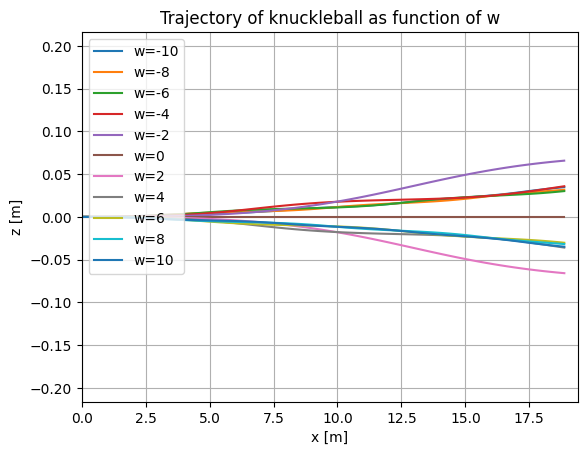

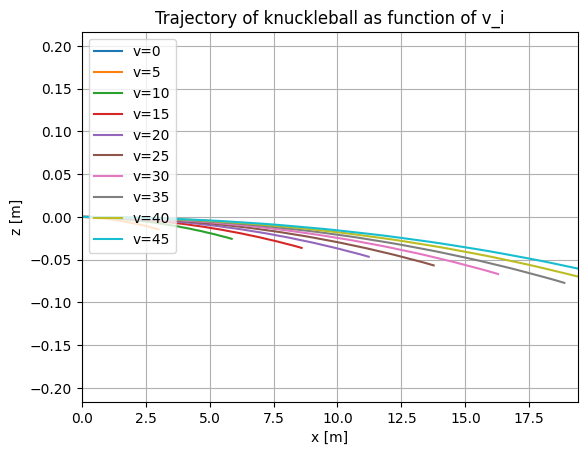

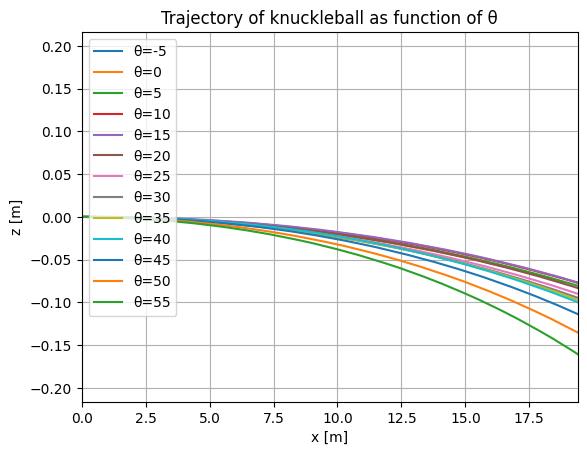

In [16]:
v_i_const = 35
theta_0 = 0
w_arr = np.arange(-10, 10+1, 2)
knuckleball(f_knuckleball, "w", w_arr, v_i_const, theta_0)  # Plotting as function of angular velocity, w
w_const = 30
v_arr = np.arange(0, 50, 5)
knuckleball(f_knuckleball, "v", v_arr, theta_0, w_const)    # Plotting as function of v_initial

theta_arr = np.arange(-5, 60, 5)
knuckleball(f_knuckleball, "theta", theta_arr, v_i_const, w_const)  # Plotting as function of start angle, theta


When $\omega = \pm2$ the baseball takes the biggest sudden displacements in z-direction. This can then be deemed to be the most difficult ball to hit. Thus it's not the ball with the most spin that is the "most unpredictable", the closer $\omega$ gets to zero the bigger the displacement. As a function $F_{lateral}$ decreases with $\theta$. So the optimal throw is with an angle close to zero (with respect to the vector from pitcher to hitter) and with as little spin as possible. 

## Task 2: Golf

Firstly we will only look at the golf ball's trajectory in the xy-plane, thereby excluding any movement in z-direction. We will account for drag forces in x- and y-direction (as defined below). However we will assume that we're golfing on a day with nice weather and no wind. 

$$ \displaystyle F_{drag} = C\rho Av_iv $$ ; $\qquad
    C = 
    \begin{cases}
        \displaystyle\frac12, & v < 14\text{m/s} \\\\
        \displaystyle\frac{7.0}{v}, & v \geq 14\text{m/s}
    \end{cases}
$

Where $C$ is some drag coeffiecient, $\rho$ is the sea level air density, $A=\pi r^2$ is the cross-sectional area and $r$ the radius of the ball, $v_i$ is the velocity in a given direction and $v$ is the total velocity of the ball.

We will also take into account the Magnus force. This is a result from the spin of the golf ball, and is defined as:

$$ \displaystyle \frac{S_0v_i\omega}{m} $$.

Where $S_0$ is a numerical coeffiecient obtained from averaging the drag force over the face of the ball, $v_i$ is the velocity in a given direction, $\omega$ is the angular velocity of the ball and $m$ is the mass of the ball.

Our total system then becomes:

$$ \displaystyle q=[x, v_x, y, v_y] = \left[v_x,\space -\frac{F_{drag,x}}{m} - \frac{S_0v_y\omega}{m},\space v_y, \space -\frac{F_{drag,x}}{m} + \frac{S_0v_y\omega}{m} - g\right] $$

In [18]:
rho = 1.225 # kg/m^3, air density at sea level
m_g = 45.9*1e-3 # kg, mass of golf ball
r = 21.33*1e-3 # m, radius of golf ball
A = np.pi*r**2 # m^2, approximately the face area of golf ball
sw_m = 0.25 # Hz, a good estimate for the Magnus force

def F_drag(C, rho, A, v, v_dir):
    return C*rho*A*abs(v)*v_dir

def F_Magnus(S_0w_m, v):
    return m_g*np.cross(S_0w_m, v)

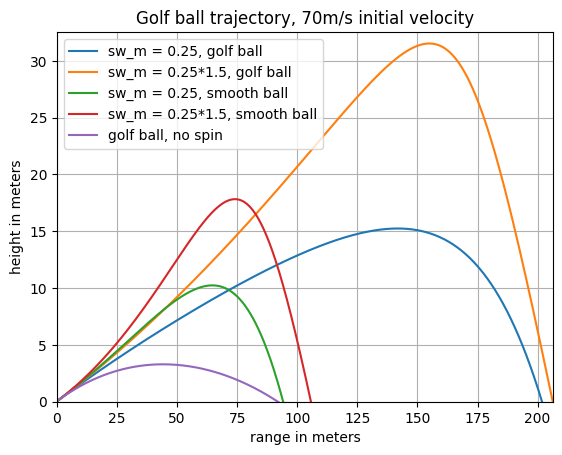

In [19]:
w = 2800/60*2*np.pi
sw_m = 0.25 # Hz, a good estimate for the Magnus force
v_i = 70 #m/s, initial velocity
theta_i = 9*np.pi/180 # 9 degrees to radians, initial angle
y_i = 3.81*1e-2 #m , height of golf peg
x_i = 0
q0 = np.array([x_i, v_i*np.cos(theta_i), y_i, v_i*np.sin(theta_i)])

def C_func(v):

    if abs(v) < 14:
        return 0.5
    elif abs(v) >= 14: 
        return 7/v
    
    print('nå ble det feil')
    return 0.5

def f_golf(t, q):

    v_arr = np.array([q[1], q[3]])

    if q[1] >= 14:
        Cx = 7/q[1]
    else:
        Cx = 0.5
    if abs(q[3]) >= 14:
        Cy = 7/abs(q[3])
    else:
        Cy = 0.5

    drag_x = F_drag(Cx, rho, A, np.linalg.norm(v_arr), q[1])
    drag_y = F_drag(Cy, rho, A, np.linalg.norm(v_arr), q[3])
    dq = np.array([q[1], -drag_x/m_g - sw_m*q[3], 
                    q[3], -drag_y/m_g + sw_m*q[1] - g])

    return dq

def f_smooth(t, q):

    v_arr = np.array([q[1], q[3]])
    C = 0.5
    drag_x = F_drag(C, rho, A, np.linalg.norm(v_arr), q[1])
    drag_y = F_drag(C, rho, A, np.linalg.norm(v_arr), q[3])
    dq = np.array([q[1], -drag_x/m_g - sw_m*q[3], 
                    q[3], -drag_y/m_g + sw_m*q[1] - g])

    return dq


q1, _ = ode_solver(f_golf, q0, 0, 1e-2)
q1_smooth, _ = ode_solver(f_smooth, q0, 0, 1e-2)

sw_m = 1.5*sw_m # Changing the Magnus force
q2, _ = ode_solver(f_golf, q0, 0, 1e-2)
q2_smooth, _ = ode_solver(f_smooth, q0, 0, 1e-2)

sw_m = 0*sw_m
q_nospin, _ = ode_solver(f_golf, q0, 0, 1e-2)


plt.figure()
plt.title("Golf ball trajectory, 70m/s initial velocity")
plt.plot(q1[0], q1[2], label = "sw_m = 0.25, golf ball")
plt.plot(q2[0], q2[2], label = "sw_m = 0.25*1.5, golf ball")
plt.plot(q1_smooth[0], q1_smooth[2], label = "sw_m = 0.25, smooth ball")
plt.plot(q2_smooth[0], q2_smooth[2], label = "sw_m = 0.25*1.5, smooth ball")
plt.plot(q_nospin[0], q_nospin[2], label= "golf ball, no spin")
plt.xlim(0, np.max(q2[0])); plt.ylim(0, np.max(q2[2]+1))
plt.xlabel("range in meters"); plt.ylabel("height in meters")
plt.grid(); plt.legend(loc = 2)
plt.show()


# plt.xlim(0, np.max(q1_smooth[0])); plt.ylim(0, np.max(q1_smooth[2])+1)
# plt.xlabel("range in meters"); plt.ylabel("height in meters")
# plt.grid(); plt.legend()
# plt.show()

First of all the balls that travels the furthest is the two golf balls that are spinning. The golf ball effect, an effect that is a result of the dimples on the ball which "holds" the air for a longer time. So that the boundary layer extends fruther behind the ball (than a smooth ball) and reduces the wake. This is the reason for the $7/v$ dependancy for the drag coefficient of the golf ball. This makes the ball travel further before the speed drops off and it falls to the ground. From the figure above it is observed that the golf ball travels approximately twice the distance than the corresponding smooth ball. The only difference being the dimples in the golf ball. 

One can also see how big the effect of the Magnus force is. With $S_0\omega/m = 0.25$ the distance is more than twice as long than the golf ball without spin. This is with the same initial velocity and angle! 

Now we will take into account movement in the z-direction as well. That means that the Magnus force is defined as:

$$ \displaystyle \vec{F}_M = S_0\vec{\omega}\times\vec{v}$$.

The system we have to solve then becomes:

$$ \displaystyle q=[x, v_x, y, v_y, z, v_z] = \left[v_x,\space -\frac{F_{drag,x}}{m} - \frac{S_0\omega_zv_y}{m},\space v_y, \space -\frac{F_{drag,y}}{m} + \frac{S_0(\omega_zv_x - \omega_xv_z)}{m} - g,\space v_z,\space -\frac{F_{drag,z}}{m} + \frac{S_0\omega_xv_y}{m} \right] $$

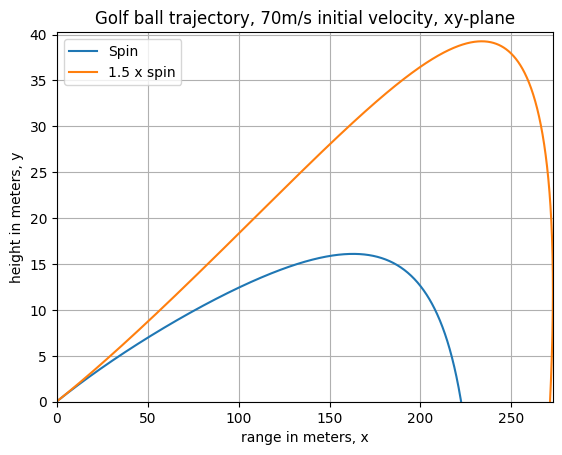

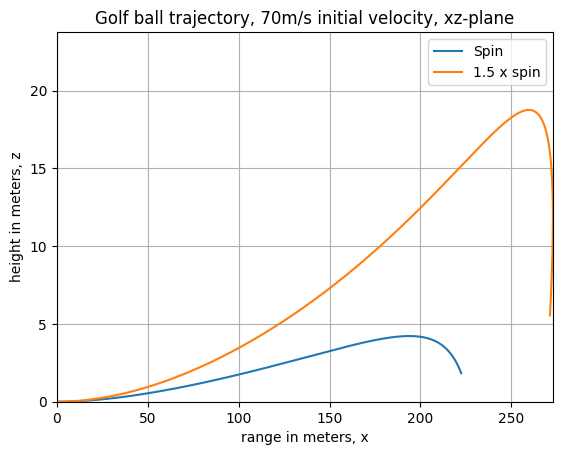

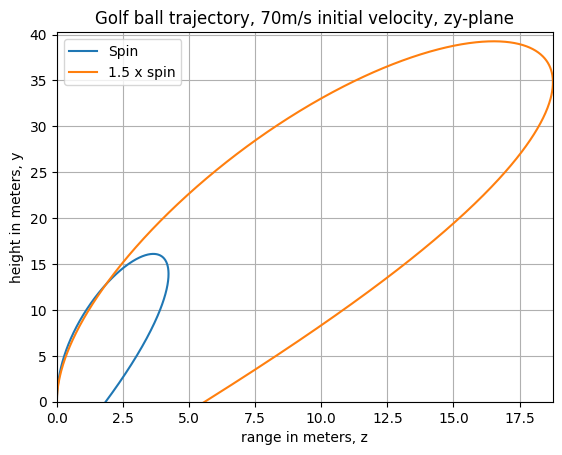

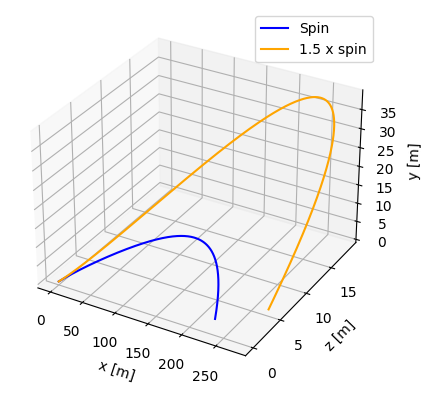

In [21]:
spin_arr = np.array([0.25, 0, 0.25]) # Added spin in x-direction

def f(t, q):

    v = np.array([q[1], q[3], q[5]])
    if q[1] >= 14:
        Cx = 7/q[1]
    else:
        Cx = 0.5
    if abs(q[3]) >= 14:
        Cy = 7/abs(q[3])
    else:
        Cy = 0.5
    if abs(q[5]) >= 14:
        Cz = 7/abs(q[5])
    else:
        Cz = 0.5

    dq = np.array([q[1], - F_drag(Cx, rho, A, np.linalg.norm(v), q[1])/m_g - F_Magnus(spin_arr, v)[0]/m_g, 
                    q[3], - F_drag(Cy, rho, A, np.linalg.norm(v), q[3])/m_g + F_Magnus(spin_arr, v)[1]/m_g - g,
                    q[5], - F_drag(Cz, rho, A, np.linalg.norm(v), q[5])/m_g + F_Magnus(spin_arr, v)[2]/m_g])

    return dq

q0 = np.array([x_i, v_i*np.cos(theta_i), y_i, v_i*np.sin(theta_i), 0, 0])
q, _ = ode_solver(f, q0, 0, 1e-2)

spin_arr = spin_arr * 1.5  # 50% more spin
q_2, _ = ode_solver(f, q0, 0, 1e-2)

plt.figure()
plt.title("Golf ball trajectory, 70m/s initial velocity, xy-plane")
plt.plot(q[0], q[2], label='Spin')
plt.plot(q_2[0], q_2[2], label='1.5 x spin')
plt.xlim(0, np.max(q_2[0])); plt.ylim(0, np.max(q_2[2]+1))
plt.xlabel("range in meters, x"); plt.ylabel("height in meters, y")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title("Golf ball trajectory, 70m/s initial velocity, xz-plane")
plt.plot(q[0], q[4], label='Spin')
plt.plot(q_2[0], q_2[4], label='1.5 x spin')
plt.xlim(0, np.max(q_2[0])); plt.ylim(0, np.max(q_2[4]+5))
plt.xlabel("range in meters, x"); plt.ylabel("height in meters, z")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title("Golf ball trajectory, 70m/s initial velocity, zy-plane")
plt.plot(q[4], q[2], label='Spin')
plt.plot(q_2[4], q_2[2], label='1.5 x spin')
plt.xlim(0, np.max(q_2[4])); plt.ylim(0, np.max(q_2[2]+1))
plt.xlabel("range in meters, z"); plt.ylabel("height in meters, y")
plt.legend()
plt.grid()
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(q[0], q[4], q[2],'blue', label='Spin')
ax.plot3D(q_2[0], q_2[4], q_2[2], 'orange', label = '1.5 x spin')
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_zlabel('y [m]')
ax.legend()

It is observed that the ball travels a few meters in the z-direction and then turns and travels towards $z=0$ again. This is because when $v_y$ changes sign, so does the direction of the Magnus force in the z-direction, so that the ball travels back again. This is nice, so that the golfers don't have to aim 20 meters to the right of where they want to land (without wind). The ball travels so far that $v_x$ also changes sign. However it travels further with spin in x-component than without. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0438b2eb-b116-40ca-9226-a0ffa4d3eb5f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>